# CIFAR-10 с трюками

В этом задании мы продолжим работать с CIFAR-10, опробовав трюки, про которые мы узнали в 4 модуле.

Датасет CIFAR-10 состоит из цветных картинок 32x32, разделенных на 10 классов:

__airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__

# Импорты

In [1]:
!pip install -q tensorflow==2.1

ERROR: Could not find a version that satisfies the requirement tensorflow==2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1)
ERROR: No matching distribution found for tensorflow==2.1


In [2]:
import tensorflow as tf
import keras
import keras.models as M
import keras.layers as L
import keras.backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.15.0
2.15.0


# Загружаем данные

In [3]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


In [4]:
print("Трейн:", x_train.shape, y_train.shape)
print("Тест:", x_test.shape, y_test.shape)

Трейн: (50000, 32, 32, 3) (50000, 1)
Тест: (10000, 32, 32, 3) (10000, 1)


In [5]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

In [8]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

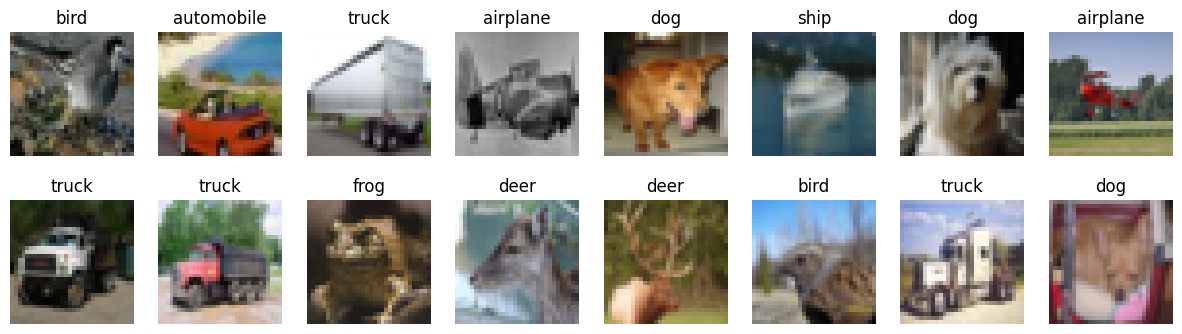

In [9]:
# посмотрим на примеры картинок
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Готовим данные

Не забудьте нормализовать картинки: $$x_{norm} = \frac{x}{255} - 0.5$$

А еще нужно превратить метки в one-hot вектора при помощи __keras.utils.to_categorical__.

In [11]:
# нормализуем входы (в результате получаем данные от -0.5 до +0.5)
x_train2 = x_train.astype('float32') / 255 - 0.5
x_test2 = x_test.astype('float32') / 255 - 0.5

# конвертируем метки в np.array (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Задаем *дефолтную* архитектуру сети

In [12]:
# слои, которые нам пригодятся
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

Нам понадобятся такие слои:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - сверточный слой:
    - **filters**: количество фильтров на выходе;
    - **kernel_size**: размер скользящего окна;
    - **padding**: padding="same" добивает нулями, чтобы ширина и высота на выходе не изменились, padding='valid' берет только окна, которые полностью помещаются в картинке;
    - **activation**: "relu", "tanh", итд;
    - **input_shape**: размер входа вида (W, H, C_in).
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - пулинг
- [Flatten](https://keras.io/layers/core/#flatten) - все оси, кроме батча (первой) вытягиваются в один вектор.
- [Dense](https://keras.io/layers/core/#dense) - плотный, активацию можно задать через activation="elu" или activation="softmax".
- [Dropout](https://keras.io/layers/core/#dropout) - дропаут регуляризация (без нее сеть сильно переобучается), позже узнаем какой у нее смысл.

Ваша модель должна принимать на вход цветную картинку __(None, 32, 32, 3)__ и предсказывать вероятности 10 классов __(None, 10)__.

Добавьте __4__ сверточных слоя с окном __(3, 3)__ с нарастающим количеством фильтров: __(16, 32, 32, 64)__, используйте "same" паддинг.

Добавьте __2x2__ макс пулинг после каждых 2 сверточных слоев (conv-conv-pool схема).

Используйте __activation='relu'__ для всех слоев, где это нужно.

Добавьте плотный слой из __256__ нейронов и еще один из __10__ нейронов для предсказания выходов. Не забудьте применить __Flatten__ перед первым плотным слоем!

Для регуляризации сети вставьте Dropout после каждого пулинг слоя (с параметром** 0.25**) и между плотными слоями на выходе (с параметром **0.5**).

В дальнейшем будем называть эту архитектуру **дефолтной** и будем исследовать небольшие изменения в ней!

In [19]:
def make_default_model():
    model = Sequential()
    model.add(L.Conv2D(16, kernel_size=3, activation='relu', strides=1, padding='same', input_shape=(32, 32, 3)))
    model.add(L.Conv2D(32, kernel_size=3, activation='relu', strides=1, padding='same'))
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Conv2D(32, kernel_size=3, activation='relu', strides=1, padding='same'))
    model.add(L.Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='same'))
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Flatten())
    model.add(L.Dense(256, activation='softmax'))
    model.add(L.Dropout(0.5))
    model.add(L.Dense(10, activation='softmax'))

    return model

In [20]:
K.clear_session()
model = make_default_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        18496     
                                                        

# Тренируем модель

In [21]:
def train_model(make_model_func=make_default_model, optimizer="adam"):
  BATCH_SIZE = 32
  EPOCHS = 10

  K.clear_session()
  model = make_model_func()

  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy']
  )

  model.fit(
      x_train2, y_train2,  # нормализованные данные
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(x_test2, y_test2),
      shuffle=False
  )

  return model

Давайте посмотрим, что будет с дефолтной моделью (модель = make_default_model, оптимайзер = "adam"), если ее немного поменять:


Часть 1 :
1.   Какое качество (accuracy) на валидации дает **дефолтная архитектура**?

Часть 2:
2.   Измените в дефолтной архитектуре **relu активацию на sigmoid**, какое качество на валидации получили?
3.   Измените в дефолтной архитектуре **adam оптимайзер на sgd**, какое качество на валидации получили?
4.   Добавьте к дефолтной архитектуре **батч нормализацию** после каждого сверточного слоя и после перового полносвязного (model.add(BatchNormalization())), какое качество на валидации получили?
5.   Добавьте к дефолтной архитектуре **батч нормализацию** и смените **relu активацию на sigmoid**,  какое качество на валидации получили?
  
*Рекомендуется завести свою функцию для каждого изменения архитектуры!*


##Какое качество (accuracy) на валидации дает дефолтная архитектура?

In [22]:
# учим дефолтную архитектуру
train_model()

Epoch 1/10
1563/1563 [==============================] - 18s 7ms/step - loss: 2.2124 - accuracy: 0.1548 - val_loss: 2.1016 - val_accuracy: 0.2432
Epoch 2/10
1563/1563 [==============================] - 10s 7ms/step - loss: 2.0976 - accuracy: 0.1990 - val_loss: 1.9542 - val_accuracy: 0.3349
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.9356 - accuracy: 0.3036 - val_loss: 1.7237 - val_accuracy: 0.4848
Epoch 4/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.7675 - accuracy: 0.3760 - val_loss: 1.5271 - val_accuracy: 0.5372
Epoch 5/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.6431 - accuracy: 0.4227 - val_loss: 1.3849 - val_accuracy: 0.5804
Epoch 6/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.5448 - accuracy: 0.4624 - val_loss: 1.2882 - val_accuracy: 0.6082
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4707 - accuracy: 0.4945 - val_loss: 1.2156 - val_accu

##Измените в дефолтной архитектуре relu активацию на **sigmoid**, какое качество на валидации получили?

In [23]:
def make_sigmoid_model():
    model = Sequential()
    model.add(L.Conv2D(16, kernel_size=3, activation='sigmoid', strides=1, padding='same', input_shape=(32, 32, 3)))
    model.add(L.Conv2D(32, kernel_size=3, activation='sigmoid', strides=1, padding='same'))
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Conv2D(32, kernel_size=3, activation='sigmoid', strides=1, padding='same'))
    model.add(L.Conv2D(64, kernel_size=3, activation='sigmoid', strides=1, padding='same'))
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Flatten())
    model.add(L.Dense(256, activation='softmax'))
    model.add(L.Dropout(0.5))
    model.add(L.Dense(10, activation='softmax'))

    return model

In [24]:
# учим sigmoid
train_model(make_sigmoid_model)

Epoch 1/10
1563/1563 [==============================] - 12s 7ms/step - loss: 2.3037 - accuracy: 0.0992 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 2/10
1563/1563 [==============================] - 10s 6ms/step - loss: 2.3030 - accuracy: 0.0980 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 2.3030 - accuracy: 0.0960 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 4/10
1563/1563 [==============================] - 10s 6ms/step - loss: 2.3029 - accuracy: 0.0997 - val_loss: 2.3028 - val_accuracy: 0.1000
Epoch 5/10
1563/1563 [==============================] - 10s 7ms/step - loss: 2.3031 - accuracy: 0.0954 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 6/10
1563/1563 [==============================] - 12s 7ms/step - loss: 2.3030 - accuracy: 0.0970 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 7/10
1563/1563 [==============================] - 10s 7ms/step - loss: 2.3030 - accuracy: 0.0968 - val_loss: 2.3028 - val_ac

##Измените в дефолтной архитектуре adam оптимайзер на **sgd**, какое качество на валидации получили?

In [25]:
# учим sgd
train_model(optimizer="sgd")

Epoch 1/10
1563/1563 [==============================] - 11s 6ms/step - loss: 2.3027 - accuracy: 0.0968 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3027 - accuracy: 0.0955 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 2.3027 - accuracy: 0.0979 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/10
1563/1563 [==============================] - 10s 6ms/step - loss: 2.3027 - accuracy: 0.0988 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/10
1563/1563 [==============================] - 9s 5ms/step - loss: 2.3027 - accuracy: 0.0980 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/10
1563/1563 [==============================] - 10s 7ms/step - loss: 2.3027 - accuracy: 0.0979 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step - loss: 2.3027 - accuracy: 0.0966 - val_loss: 2.3026 - val_accu

Добавьте к дефолтной архитектуре **батч нормализацию** после каждого сверточного слоя и после перового полносвязного (`model.add(BatchNormalization())`), какое качество на валидации получили?

In [26]:
def make_bn_model():
    model = Sequential()
    model.add(L.Conv2D(16, kernel_size=3, activation='relu', strides=1, padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(L.Conv2D(32, kernel_size=3, activation='relu', strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Conv2D(32, kernel_size=3, activation='relu', strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(L.Conv2D(64, kernel_size=3, activation='relu', strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Flatten())
    model.add(BatchNormalization())
    model.add(L.Dense(256, activation='softmax'))
    model.add(L.Dropout(0.5))
    model.add(L.Dense(10, activation='softmax'))

    return model

In [27]:
# учим bn
train_model(make_bn_model)

Epoch 1/10
1563/1563 [==============================] - 18s 9ms/step - loss: 2.1387 - accuracy: 0.2048 - val_loss: 2.0012 - val_accuracy: 0.3447
Epoch 2/10
1563/1563 [==============================] - 13s 8ms/step - loss: 2.0481 - accuracy: 0.2279 - val_loss: 1.9810 - val_accuracy: 0.3111
Epoch 3/10
1563/1563 [==============================] - 13s 8ms/step - loss: 2.0083 - accuracy: 0.2431 - val_loss: 1.8403 - val_accuracy: 0.3940
Epoch 4/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.9846 - accuracy: 0.2477 - val_loss: 1.7852 - val_accuracy: 0.4104
Epoch 5/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.9593 - accuracy: 0.2632 - val_loss: 1.7351 - val_accuracy: 0.4406
Epoch 6/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.9444 - accuracy: 0.2762 - val_loss: 1.7359 - val_accuracy: 0.4598
Epoch 7/10
1563/1563 [==============================] - 13s 8ms/step - loss: 1.9339 - accuracy: 0.2833 - val_loss: 1.6935 - val_ac

Добавьте к дефолтной архитектуре батч нормализацию и смените relu активацию на sigmoid, какое качество на валидации получили?

In [28]:
def make_sigmoid_bn_model():
    model = Sequential()
    model.add(L.Conv2D(16, kernel_size=3, activation='sigmoid', strides=1, padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(L.Conv2D(32, kernel_size=3, activation='sigmoid', strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Conv2D(32, kernel_size=3, activation='sigmoid', strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(L.Conv2D(64, kernel_size=3, activation='sigmoid', strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(L.MaxPool2D())
    model.add(L.Dropout(0.25))
    model.add(L.Flatten())
    model.add(BatchNormalization())
    model.add(L.Dense(256, activation='softmax'))
    model.add(L.Dropout(0.5))
    model.add(L.Dense(10, activation='softmax'))

    return model

In [29]:
# учим sigmoid + bn
train_model(make_sigmoid_bn_model)

Epoch 1/10
1563/1563 [==============================] - 17s 9ms/step - loss: 2.1890 - accuracy: 0.1799 - val_loss: 2.0865 - val_accuracy: 0.2930
Epoch 2/10
1563/1563 [==============================] - 13s 9ms/step - loss: 2.1088 - accuracy: 0.2098 - val_loss: 1.9728 - val_accuracy: 0.3314
Epoch 3/10
1563/1563 [==============================] - 14s 9ms/step - loss: 2.0674 - accuracy: 0.2228 - val_loss: 1.9243 - val_accuracy: 0.3454
Epoch 4/10
1563/1563 [==============================] - 13s 9ms/step - loss: 2.0199 - accuracy: 0.2365 - val_loss: 1.8566 - val_accuracy: 0.3842
Epoch 5/10
1563/1563 [==============================] - 13s 8ms/step - loss: 2.0044 - accuracy: 0.2490 - val_loss: 1.8265 - val_accuracy: 0.4017
Epoch 6/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.9889 - accuracy: 0.2524 - val_loss: 1.8241 - val_accuracy: 0.3912
Epoch 7/10
1563/1563 [==============================] - 13s 9ms/step - loss: 1.9720 - accuracy: 0.2613 - val_loss: 1.7878 - val_ac